This notebook is downloaded from [scikit-survival user guide](https://github.com/sebp/scikit-survival/tree/v0.22.2/doc/user_guide)

# Introduction to Survival Analysis with scikit-survival

**scikit-survival** is a Python module for [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) built on top of [scikit-learn](https://scikit-learn.org/). It allows doing survival analysis while utilizing the power of scikit-learn, e.g., for pre-processing or doing cross-validation.


## Table of Contents

1. [What is Survival Analysis?](#What-is-Survival-Analysis?)
2. [The Veterans' Administration Lung Cancer Trial](#The-Veterans'-Administration-Lung-Cancer-Trial)
3. [Survival Data](#Survival-Data)
4. [The Survival Function](#The-Survival-Function)
5. [Considering other variables by stratification](#Considering-other-variables-by-stratification)
6. [Multivariate Survival Models](#Multivariate-Survival-Models)
7. [Measuring the Performance of Survival Models](#Measuring-the-Performance-of-Survival-Models)
8. [Feature Selection: Which Variable is Most Predictive?](#Feature-Selection:-Which-Variable-is-Most-Predictive?)
9. [What's next?](#What's-next?)

## What is Survival Analysis?

The objective in survival analysis — also referred to as reliability analysis in engineering — is to establish a connection between covariates and the time of an event. The name *survival analysis* originates from clinical research, where predicting the time to death, i.e., survival, is often the main objective. Survival analysis is a type of regression problem (one wants to predict a continuous value), but with a twist. It differs from traditional regression by the fact that parts of the training data can only be partially observed – they are *censored*.

As an example, consider a clinical study, which investigates coronary heart disease and has been carried out over a 1 year period as in the figure below.

![image censoring](https://k-d-w.org/clipboard/censoring.png)

Patient A was lost to follow-up after three months with no recorded cardiovascular event, patient B experienced an event four and a half months after enrollment, patient D withdrew from the study two months after enrollment, and patient E did not experience any event before the study ended. Consequently, the exact time of a cardiovascular event could only be recorded for patients B and C; their records are *uncensored*. For the remaining patients it is unknown whether they did or did not experience an event after termination of the study. The only valid information that is available for patients A, D, and E is that they were event-free up to their last follow-up. Therefore, their records are *censored*.

Formally, each patient record consists of a set of covariates $x \in \mathbb{R}^d$ , and the time $t>0$ when an event occurred or the time $c>0$ of censoring. Since censoring and experiencing and event are mutually exclusive, it is common to define an event indicator $\delta \in \{0;1\}$ and the observable survival time $y>0$. The observable time $y$ of a right censored sample is defined as

$$
y = \min(t, c) = 
\begin{cases} 
t & \text{if } \delta = 1 , \\ 
c & \text{if } \delta = 0 .
\end{cases}
$$

Consequently, survival analysis demands for models that take this unique characteristic of such a dataset into account, some of which are showcased below.

## The Veterans' Administration Lung Cancer Trial

The Veterans' Administration Lung Cancer Trial is a randomized trial of two treatment regimens for lung cancer. The [data set](http://lib.stat.cmu.edu/datasets/veteran) (Kalbfleisch J. and Prentice R, (1980) The Statistical Analysis of Failure Time Data. New York: Wiley) consists of 137 patients and 8 variables, which are described below:

- `Treatment`: denotes the type of lung cancer treatment; `standard` and `test` drug.
- `Celltype`: denotes the type of cell involved; `squamous`, `small cell`, `adeno`, `large`.
- `Karnofsky_score`: is the Karnofsky score.
- `Diag`: is the time since diagnosis in months.
- `Age`: is the age in years.
- `Prior_Therapy`: denotes any prior therapy; `none` or `yes`.
- `Status`: denotes the status of the patient as dead or alive; `dead` or `alive`.
- `Survival_in_days`: is the survival time in days since the treatment.

Our primary interest is studying whether there are subgroups that differ in survival and whether we can predict survival times.

## Survival Data

As described in the section *What is Survival Analysis?* above, survival times are subject to right-censoring, therefore, we need to consider an individual's status in addition to survival time. To be fully compatible with scikit-learn, `Status` and `Survival_in_days` need to be stored as a [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html) with the first field indicating whether the actual survival time was observed or if was censored, and the second field denoting the observed survival time, which corresponds to the time of death (if `Status == 'dead'`, $\delta = 1$) or the last time that person was contacted (if `Status == 'alive'`, $\delta = 0$).

In [1]:
from sksurv.datasets import load_veterans_lung_cancer

data_x, data_y = load_veterans_lung_cancer()
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

We can easily see that only a few survival times are right-censored (`Status` is `False`), i.e., most veteran's died during the study period (`Status` is `True`).

## The Survival Function

A key quantity in survival analysis is the so-called survival function, which relates time to the probability of surviving beyond a given time point.

> Let $T$ denote a continuous non-negative random variable corresponding to a patient’s survival time. The survival function $S(t)$ returns the probability of survival beyond time $t$ and is defined as
> $$ S(t) = P (T > t). $$

If we observed the exact survival time of all subjects, i.e., everyone died before the study ended, the survival function at time $t$ can simply be estimated by the ratio of patients surviving beyond time $t$ and the total number of patients:

$$
\hat{S}(t) = \frac{ \text{number of patients surviving beyond $t$} }{ \text{total number of patients} }
$$

In the presence of censoring, this estimator cannot be used, because the numerator is not always defined. For instance, consider the following set of patients:

In [2]:
import pandas as pd

pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


Using the formula from above, we can compute $\hat{S}(t=11) = \frac{3}{5}$, but not $\hat{S}(t=30)$, because we don't know whether the 4th patient is still alive at $t = 30$, all we know is that when we last checked at $t = 25$, the patient was still alive.

An estimator, similar to the one above, that *is* valid if survival times are right-censored is the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator).

In [3]:
data_y["Status"], data_y["Survival_in_days"]

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

(array([ 8., 10., 20., 25., 59.]), array([0.8, 0.6, 0.4, 0.4, 0. ]))

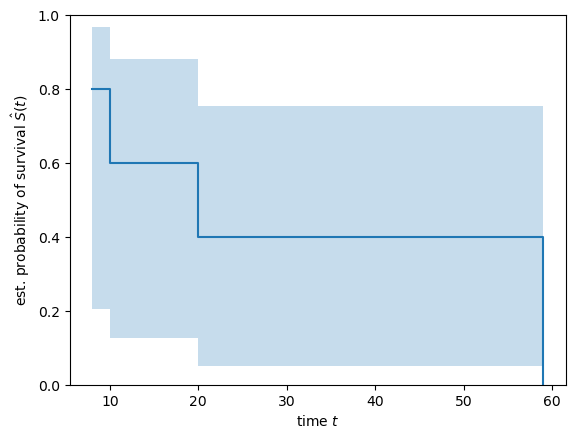

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# ?kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y[[11, 5, 32, 13, 23]]["Status"], data_y[[11, 5, 32, 13, 23]]["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

time, survival_prob

Text(0.5, 0, 'time $t$')

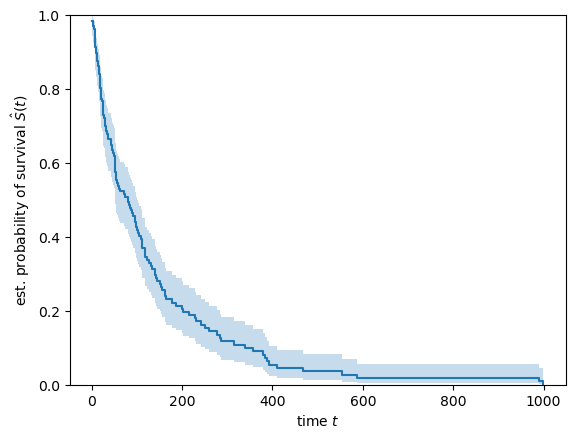

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

The estimated curve is a step function, with steps occurring at time points where one or more patients died. From the plot we can see that most patients died in the first 200 days, as indicated by the steep slope of the estimated survival function in the first 200 days.

## Considering other variables by stratification

### Survival functions by treatment

Patients enrolled in the Veterans' Administration Lung Cancer Trial were randomized to one of two treatments: `standard` and a new `test` drug. Next, let's have a look at how many patients underwent the standard treatment and how many received the new drug.

In [6]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

Roughly half the patients received the alternative treatment.

The obvious questions to ask is:
> *Is there any difference in survival between the two treatment groups?*

As a first attempt, we can estimate the survival function in both treatment groups separately.

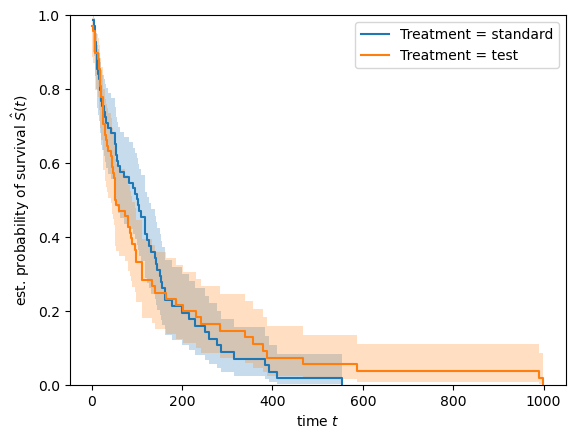

In [7]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Treatment = {treatment_type}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

Unfortunately, the results are inconclusive, because the difference between the two estimated survival functions is too small to confidently argue that the drug affects survival or not.

*Sidenote: Visually comparing estimated survival curves in order to assess whether there is a difference in survival between groups is usually not recommended, because it is highly subjective. Statistical tests such as the* [log-rank test](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.compare.compare_survival.html#sksurv.compare.compare_survival) *are usually more appropriate.*

### Survival functions by cell type

Next, let's have a look at the cell type, which has been recorded as well, and repeat the analysis from above.

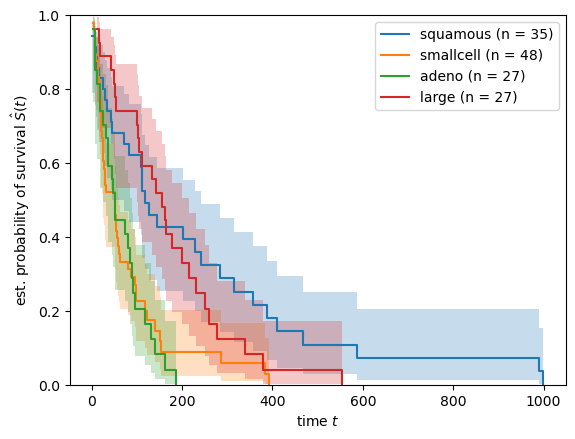

In [8]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        data_y["Status"][mask], data_y["Survival_in_days"][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In this case, we observe a pronounced difference between two groups. Patients with *squamous* or *large* cells seem to have a better prognosis compared to patients with *small* or *adeno* cells.

## Multivariate Survival Models

In the Kaplan-Meier approach used above, we estimated multiple survival curves by dividing the dataset into smaller sub-groups according to a variable. If we want to consider more than 1 or 2 variables, this approach quickly becomes infeasible, because subgroups will get very small. Instead, we can use a linear model, [Cox's proportional hazard's model](https://en.wikipedia.org/wiki/Proportional_hazards_model), to estimate the impact each variable has on survival.

First however, we need to convert the categorical variables in the data set into numeric values.

In [9]:
data_x.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard


In [10]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


Survival models in **scikit-survival** follow the same rules as estimators in scikit-learn, i.e., they have a `fit` method, which expects a data matrix and a structured array of survival times and binary event indicators.

In [ ]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

The result is a vector of coefficients, one for each variable, where each value corresponds to the [log hazard ratio](https://en.wikipedia.org/wiki/Hazard_ratio).

In [ ]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Using the fitted model, we can predict a patient-specific survival function, by passing an appropriate data matrix to the estimator's `predict_survival_function` method.

First, let's create a set of four synthetic patients.

In [ ]:
x_new = pd.DataFrame.from_dict(
    {
        1: [65, 0, 0, 1, 60, 1, 0, 1],
        2: [65, 0, 0, 1, 60, 1, 0, 0],
        3: [65, 0, 1, 0, 60, 1, 0, 0],
        4: [65, 0, 1, 0, 60, 1, 0, 1],
    },
    columns=data_x_numeric.columns,
    orient="index",
)
x_new

Similar to `kaplan_meier_estimator`, the `predict_survival_function` method returns a sequence of step functions, which we can plot.

In [ ]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post", label=f"Sample {i + 1}")
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Measuring the Performance of Survival Models

Once we fit a survival model, we usually want to assess how well a model can actually predict survival. Our test data is usually subject to censoring too, therefore metrics like root mean squared error or correlation are unsuitable. Instead, we use generalization of the area under the receiver operating characteristic (ROC) curve called [Harrell's concordance index](https://pdfs.semanticscholar.org/7705/392f1068c76669de750c6d0da8144da3304d.pdf) or c-index.

The interpretation is identical to the traditional area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) metric for binary classification:
- a value of 0.5 denotes a random model,
- a value of 1.0 denotes a perfect model,
- a value of 0.0 denotes a perfectly wrong model.

In [ ]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x_numeric)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

or alternatively

In [ ]:
estimator.score(data_x_numeric, data_y)

Our model's c-index indicates that the model clearly performs better than random, but is also far from perfect.

## Feature Selection: Which Variable is Most Predictive?

The model above considered all available variables for prediction. Next, we want to investigate which single variable is the best risk predictor. Therefore, we fit a Cox model to each variable individually and record the c-index on the training set.

In [ ]:
import numpy as np


def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

`Karnofsky_score` is the best variable, whereas `Months_from_Diagnosis` and `Prior_therapy='yes'` have almost no predictive power on their own.

Next, we want to build a parsimonious model by excluding irrelevant features. We could use the ranking from above, but would need to determine what the optimal cut-off should be. Luckily, scikit-learn has built-in support for performing grid search.

First, we create a pipeline that puts all the parts together.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("encode", OneHotEncoder()),
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

Next, we need to define the range of parameters we want to explore during grid search. Here, we want to optimize the parameter `k` of the `SelectKBest` class and allow `k` to vary from 1 feature to all 8 features.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

param_grid = {"select__k": np.arange(1, data_x_numeric.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, data_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]

The results show that it is sufficient to select the 5 most predictive features.

In [ ]:
pipe.set_params(**gcv.best_params_)
pipe.fit(data_x, data_y)

encoder, transformer, final_estimator = [s[1] for s in pipe.steps]
pd.Series(final_estimator.coef_, index=encoder.encoded_columns_[transformer.get_support()])

## What's next?

Cox's proportional hazards model is by far the most popular survival model, because once trained, it is easy to interpret. However, if prediction performance is the main objective, more sophisticated, non-linear or ensemble models might lead to better results.
Before you dive deeper into the various survival models, it is highly recommended reading [this notebook](evaluating-survival-models.ipynb) for getting a better understanding on how to evaluate survival models.
The [User Guide](https://scikit-survival.readthedocs.io/en/latest/user_guide/index.html) is a good starting point to learn more about various models implemented in **scikit-survival**, and the [API reference](https://scikit-survival.readthedocs.io/en/latest/api/index.html) contains a full list of available classes and functions and their parameters. In addition, you can use any unsupervised pre-processing method available with scikit-learn, for instance, you could perform dimensionality reduction using [Non-Negative Matrix Factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF), before training a Cox model.